# Notebook 02b: S3 Data Validation & EDA

**Goal**: Validate the synthetic data uploaded to S3 in the previous step.

**Steps**:
1. Download the raw dataset from S3.
2. Load into Pandas.
3. Perform Exploratory Data Analysis (EDA):
   - Check data integrity (missing values, types).
   - Visualize key metrics (CPU, Memory, Network).
   - Verify seasonality patterns (Weekly, Quarterly).
4. Confirm data is ready for Feature Engineering.

In [10]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as pd_plt
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src to path for imports
current_dir = Path(os.getcwd())
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils.aws_utils import download_from_s3, get_aws_session
from src.utils.config import get_data_config, get_aws_config

# Setup plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

## 1. Fetch Data from S3

In [11]:
# Load configs
aws_config = get_aws_config()
data_config = get_data_config()

bucket_name = aws_config['bucket_name']
raw_prefix = aws_config.get('raw_prefix', 'raw/server_metrics/')
file_name = "server_metrics.csv.gz"
s3_key = f"{raw_prefix}{file_name}"

# Define local download path (temporary)
local_download_path = project_root / "data" / "scratch" / file_name

print(f"Downloading s3://{bucket_name}/{s3_key} to {local_download_path}...")

# Download
# Note: ensuring session uses the 'study' profile set in config
try:
    download_from_s3(bucket_name, s3_key, str(local_download_path))
    print("Download successful!")
except Exception as e:
    print(f"Error downloading: {e}")
    # Fallback for local testing if S3 fails (optional)
    fallback_path = project_root / data_config.get('generated_data_path')
    if fallback_path.exists():
        print(f"Falling back to local file: {fallback_path}")
        local_download_path = fallback_path

Download successful!


## 2. Load & Inspect Data

In [12]:
df = pd.read_csv(local_download_path, parse_dates=['timestamp'], index_col='timestamp')
print(f"Shape: {df.shape}")
display(df.head())

Shape: (175320, 18)


,server_id,cpu_p95,mem_p95,disk_p95,net_in_p95,net_out_p95,app_name,business_unit,criticality,region,server_type,year,month,quarter,dayofweek,is_weekend,is_eoq,is_holiday
timestamp,,,,,,,,,,,,,,,,,,
2022-01-01,server_000,23.92,21.36,23.72,74.13,44.48,app_000,Compliance,High,Asia,web,2022,1,1,5,1,0,1
2022-01-02,server_000,8.27,15.54,21.60,42.71,25.63,app_000,Compliance,High,Asia,web,2022,1,1,6,1,0,0
2022-01-03,server_000,41.18,25.22,18.32,101.99,61.20,app_000,Compliance,High,Asia,web,2022,1,1,0,0,0,0
2022-01-04,server_000,45.25,40.18,25.78,153.76,92.25,app_000,Compliance,High,Asia,web,2022,1,1,1,0,0,0
2022-01-05,server_000,68.91,41.82,19.93,194.55,116.73,app_000,Compliance,High,Asia,web,2022,1,1,2,0,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175320 entries, 2022-01-01 to 2025-12-31
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   server_id      175320 non-null  object 
 1   cpu_p95        175320 non-null  float64
 2   mem_p95        175320 non-null  float64
 3   disk_p95       175320 non-null  float64
 4   net_in_p95     175320 non-null  float64
 5   net_out_p95    175320 non-null  float64
 6   app_name       175320 non-null  object 
 7   business_unit  175320 non-null  object 
 8   criticality    175320 non-null  object 
 9   region         175320 non-null  object 
 10  server_type    175320 non-null  object 
 11  year           175320 non-null  int64  
 12  month          175320 non-null  int64  
 13  quarter        175320 non-null  int64  
 14  dayofweek      175320 non-null  int64  
 15  is_weekend     175320 non-null  int64  
 16  is_eoq         175320 non-null  int64  
 17  is_holiday   

In [14]:
# Check for missing values
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✅ No missing values found.")
else:
    display(missing[missing > 0])

✅ No missing values found.


## 3. Exploratory Analysis
### 3.1 Overall Distribution

In [15]:
metrics = ['cpu_p95', 'mem_p95', 'disk_p95', 'net_in_p95']
df[metrics].describe().round(2)

,cpu_p95,mem_p95,disk_p95,net_in_p95
count,175320.00,175320.00,175320.00,175320.00
mean,40.06,44.58,31.33,110.66
std,20.22,19.49,16.08,52.95
min,0.00,0.00,0.00,0.00
25%,26.15,30.75,19.90,74.38
50%,39.49,42.89,26.89,107.54
75%,53.14,58.34,39.34,143.73
max,100.00,100.00,100.00,444.75


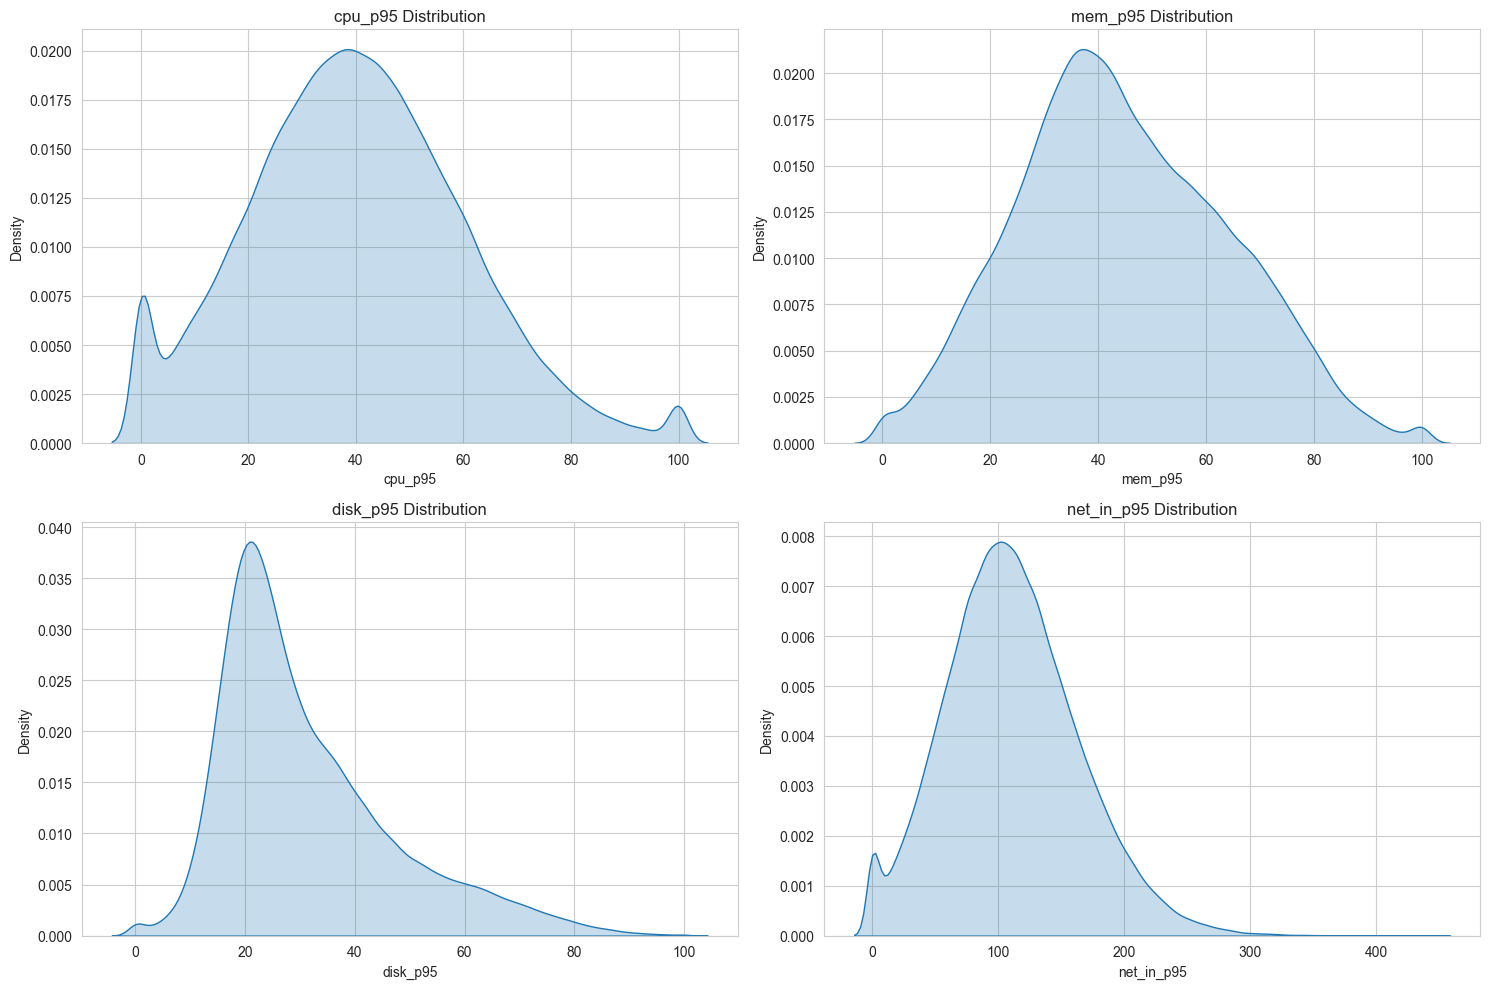

In [16]:
# Density Plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(df[col], fill=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

### 3.2 Time Series Patterns (Sample Server)
We inspect specific servers to verify expected archetypes (e.g., 'Web' should have high correlations).

Visualizing Server: server_000 (web)


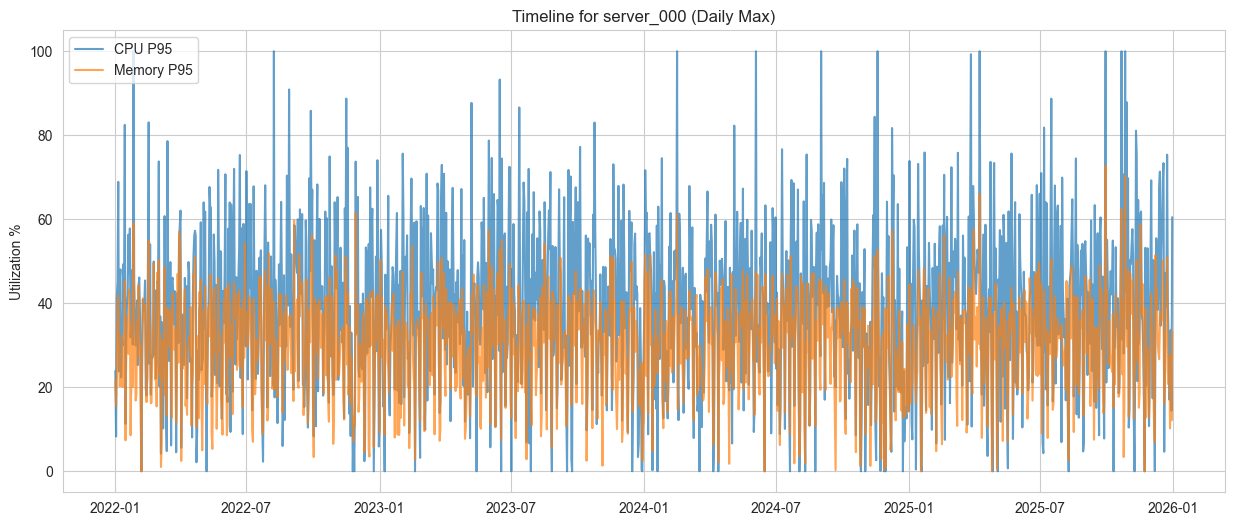

In [17]:
# Pick a random Web server
if 'server_type' in df.columns:
    web_servers = df[df['server_type'] == 'web']['server_id'].unique()
    sample_id = web_servers[0] if len(web_servers) > 0 else df['server_id'].iloc[0]
else:
    sample_id = df['server_id'].unique()[0]

print(f"Visualizing Server: {sample_id} ({df[df['server_id']==sample_id]['server_type'].iloc[0] if 'server_type' in df.columns else 'Unknown'})")

sample_df = df[df['server_id'] == sample_id].sort_index()

# Resample to daily max for cleaner plot over 4 years
daily_view = sample_df[metrics].resample('D').max()

plt.figure(figsize=(15, 6))
plt.plot(daily_view.index, daily_view['cpu_p95'], label='CPU P95', alpha=0.7)
plt.plot(daily_view.index, daily_view['mem_p95'], label='Memory P95', alpha=0.7)
plt.title(f"Timeline for {sample_id} (Daily Max)")
plt.ylabel("Utilization %")
plt.legend()
plt.show()

### 3.3 Verify Seasonality & Quarterly Peaks
Zooming into a quarter-end (e.g., March 2024).

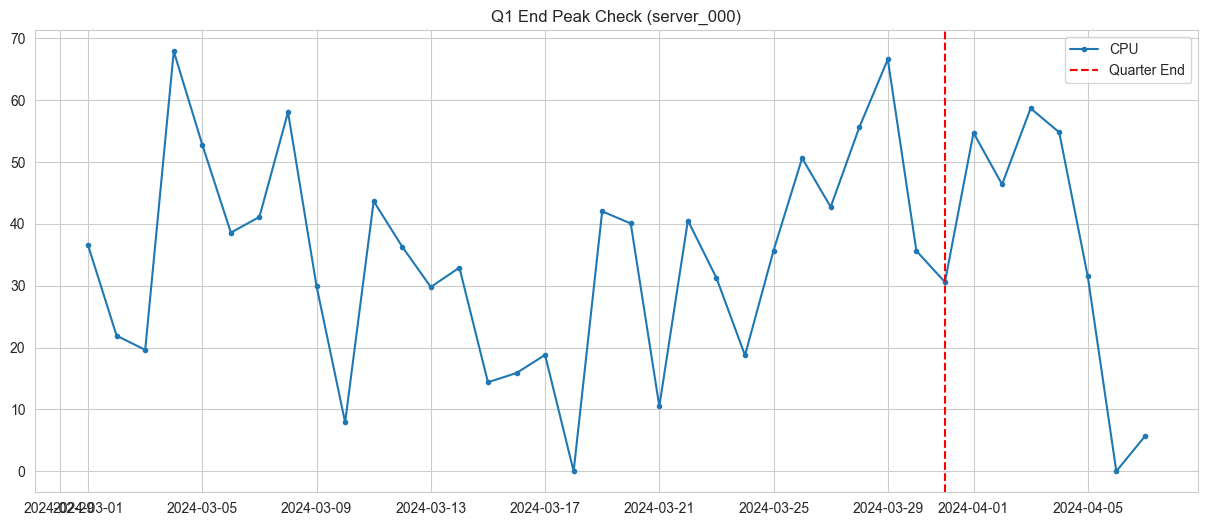

In [18]:
# Zoom in on Q1 2024
zoom_start = '2024-03-01'
zoom_end = '2024-04-07'

mask = (sample_df.index >= zoom_start) & (sample_df.index <= zoom_end)
zoomed = sample_df[mask]

plt.figure(figsize=(15, 6))
plt.plot(zoomed.index, zoomed['cpu_p95'], marker='o', markersize=3, label='CPU')
plt.axvline(pd.Timestamp('2024-03-31'), color='r', linestyle='--', label='Quarter End')
plt.title(f"Q1 End Peak Check ({sample_id})")
plt.legend()
plt.show()